# Lab 7 - Convolutional Neural Networks

### Eric Smith and Jake Carlson

## Introduction
In this lab, we will develop a multi-layer perceptron to perform classification on the CIFAR-10 data set. Similar to Lab 3, we will subset the data set to images of trucks and automobiles. The original data set has 60,000 images. 50,000 of these are training images and 10,000 are test images. The images are 32x32 pixels and contain objects from 10 classes. The classes are listed below.
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

This data set was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton for their paper <i>Learning Multiple Layers of Features from Tiny Images</i>. In this study, the authors use several filters to train their model to learn interesting regularities in the set of images, rather than focus on correlations between nearby pixels [1].

For this lab, we will use the images of automobile, trucks, and birds. The trucks, in this case, are semi-trucks. We have been guaranteed by the people who generated the data set that these three classes are mutually exclusive. The automobile class will have images of sedans and SUVs. The truck class will have big trucks only. Neither class has images of pickup trucks.

## Business Understanding

### Motivations
The law treats cars and trucks differently on the road. Trucks often have to stop at weigh stations so their contents can be verified. It would be useful to have a tool that can distinguish between cars and trucks. Once a truck has been identified, a record of the truck and its location can be made so that Customs or local authorities can make sure the truck is checked at the next weigh station.

The classification system developed could be deployed in conjunction with CCTV cameras on the highway. This would give authorities real time metrics on how many trucks are passing through an area. If a truck passes by two cameras, our model could incorporate the location of each camera and the time between sightings. This would reduce the necessity of having police officers on the road to monitor the speed of semi-trucks.

If a truck is identified as speeding, a police officer could be dispatched to monitor the vehicle. Using a distributed network of cameras on the highway would mean officers could spend more time patrolling residential and commerical areas. The average annual income for a Texas state trooper is \$60,612 [2]. Positioning a trooper on the highway costs roughly \$31 an hour. Meanwhile, the cost of running a CCTV camera 24/7 is approximately 54 cents per month [3].

If a trooper is positioned on the highway, people alter their behaviors because they recognize that they are being monitored. If a criminal organization is transporting illicit substances, they can have a lead car drive ahead of the transport truck so officers can be located before the truck passes through an area. However, people often don't recognize when they are being monitored by CCTV camera.

### Objectives
Our main objective is to accurately pick out a semi-truck from a sea of automobiles. A state trooper can accurately distinguish between a semi-truck and an automobile 100% of the time. But troopers rotate in and out of an area, leaving gaps in the amount of time a road is being monitored. Take the following simplified case: one trooper is assigned to watch a highway for one business day where they start at 8am, end at 5pm, and take an hour for lunch. A second trooper rotates in to monitor the highway starting at 6pm and ending at 3am. The percentage of time the road is covered is given by
<br><br>
$$t_{officer} = \frac{24 - ((6-5) + 1 + (6-3))}{24}\times100 = 79.2\%$$


<br><br>
So 79% is our threshold to beat. In order for our algorithm to be useful to authorities, it must minimize the number of trucks that slip through undetected. We will do this by measuring the performance of our model with Recall such that
<br><br>

$$Recall = \frac{TP}{TP + FN}$$
<br>
Where TP is the true positive rate, and FN is the false negative rate.

Therefore, our objective is to minimize the number of false negatives produced and reach 79% recall to be a viable replacement for police officers.

## Data Preparation

### Data Cleaning
We will start by loading the images and subsetting to 1000 images. We will use a ratio of cars to trucks that most closely matches real-world driving conditions. A project at The George Washington University [2] puts the percentage of highway vehicles that are trucks anywhere between 5% and 25% depeding on the stretch of road. We will use 25% because it balances the classes somewhat while still conforming to a real-world estimate of the ratio between trucks and cars. We will reduce the dimensionality of our images by transforming them to gray scale. This will reduce the number of features for each image from 3,072 to 1,024. We also scale the pixel values to be between -0.5 and 0.5.

In [14]:
import numpy as np
import pandas as pd

df_labels = pd.read_csv('../Lab3/data/labels.csv')
df_labels = df_labels[ df_labels.label.isin(['automobile', 'truck']) ]
df_labels = pd.concat([df_labels[df_labels.label == "truck"].sample(n=250),
                      df_labels[df_labels.label == "automobile"].sample(n=750)])

df_labels.head()

,id,label
36541,36542,truck
4223,4224,truck
5011,5012,truck
12001,12002,truck
8783,8784,truck


In [15]:
from PIL import Image

# reads a png and returns a list of all pixel values in order r, g, b
def get_img_as_rgb_row(image_path):
    img = Image.open(image_path)
    if len(img.split()) == 4:
        # remove alpha if present
        r, g, b, a = img.split()
        img = Image.merge("RGB", (r, g, b))
    r, g, b = img.split()
    r = list(r.getdata())
    g = list(g.getdata())
    b = list(b.getdata())
    # convert to gray scale
    img_list = [(r[i] * 0.2989 + g[i] * 0.5870 + b[i] * 0.1140)/255 - 0.5 for i in range(len(r))]
    return img_list

# generate column names
cols = ['label']
for i in range(1024):
    cols.append("{}".format(i))

# create df and extract color values for all car and truck images
df = pd.DataFrame(columns=cols, index=range(len(df_labels.id.tolist())))
data_dir = "../Lab3/data/cifar-10/"
idx = 0
for r in df_labels.iterrows():
    entry = [r[1].label]
    entry.extend(get_img_as_rgb_row("{}{}.png".format(data_dir, r[1].id)))
    df.loc[idx] = entry
    idx += 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 1025 entries, label to 1023
dtypes: object(1025)
memory usage: 7.8+ MB


In [16]:
df.head()

,label,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,truck,0.271278,0.212647,0.194594,0.202756,0.226477,0.227202,0.238755,0.236175,0.236664,...,-0.301765,-0.284183,-0.279368,-0.285186,-0.260487,-0.271525,-0.286763,-0.285422,-0.293711,-0.297675
1,truck,0.246235,0.249709,0.252205,0.244809,0.251135,0.250198,0.262838,0.246041,0.271296,...,0.15088,0.14421,0.146959,0.146959,0.132168,0.113456,0.10327,0.0951494,0.0750965,0.0790176
2,truck,0.415718,0.412969,0.428207,0.464331,0.491611,0.495532,0.49436,0.486753,0.48004,...,-0.122853,-0.153261,-0.186081,-0.193283,-0.204061,-0.206599,-0.21423,-0.237757,-0.252547,-0.294044
3,truck,-0.307827,-0.293997,-0.289182,-0.284367,-0.276355,-0.275739,-0.276186,-0.269516,-0.269516,...,-0.293216,-0.310798,-0.31342,-0.307922,-0.317831,-0.342977,-0.364885,-0.363544,-0.362203,-0.365677
4,truck,0.167392,0.144076,0.284513,0.299026,0.297407,0.307593,0.33526,0.164921,0.24552,...,-0.0816906,-0.0884031,-0.0884031,-0.0927714,-0.0955204,-0.0974176,-0.110353,-0.129512,-0.150737,-0.164567


Below are the first 24 truck images in the data set.

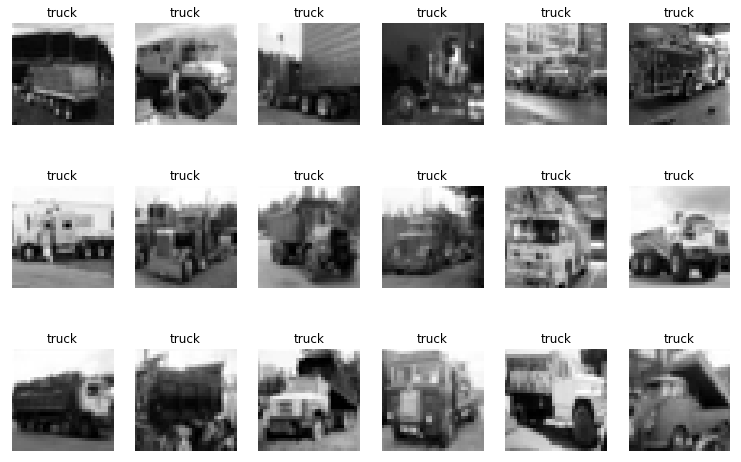

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(df.drop(['label'], axis=1).astype(np.float).values, df['label'].values, 32, 32)

In [18]:
label_dict = {
    'truck': 1,
    'automobile': 0
}
df['label_int'] = [label_dict[x] for x in df.label]
df.head()

,label,0,1,2,3,4,5,6,7,8,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label_int
0,truck,0.271278,0.212647,0.194594,0.202756,0.226477,0.227202,0.238755,0.236175,0.236664,...,-0.284183,-0.279368,-0.285186,-0.260487,-0.271525,-0.286763,-0.285422,-0.293711,-0.297675,1
1,truck,0.246235,0.249709,0.252205,0.244809,0.251135,0.250198,0.262838,0.246041,0.271296,...,0.14421,0.146959,0.146959,0.132168,0.113456,0.10327,0.0951494,0.0750965,0.0790176,1
2,truck,0.415718,0.412969,0.428207,0.464331,0.491611,0.495532,0.49436,0.486753,0.48004,...,-0.153261,-0.186081,-0.193283,-0.204061,-0.206599,-0.21423,-0.237757,-0.252547,-0.294044,1
3,truck,-0.307827,-0.293997,-0.289182,-0.284367,-0.276355,-0.275739,-0.276186,-0.269516,-0.269516,...,-0.310798,-0.31342,-0.307922,-0.317831,-0.342977,-0.364885,-0.363544,-0.362203,-0.365677,1
4,truck,0.167392,0.144076,0.284513,0.299026,0.297407,0.307593,0.33526,0.164921,0.24552,...,-0.0884031,-0.0884031,-0.0927714,-0.0955204,-0.0974176,-0.110353,-0.129512,-0.150737,-0.164567,1


In [19]:
df.to_csv('./clean-data/vehicles.csv')

### Train Test Split
We will pull out 10% of our samples to serve as a validation set for our classifier. This will allow us to gauge the generalization performance of our different models given their different architectures. We will train each model on the training set that contains 90% of our samples. In addition, to better understand how our models will generalize we will use stritified 4-fold cross validation so that we can see how our model performs on various train folds in our training set. We will only use four folds so that we don't need to dedicate too much compute resources to evaluating our models.

In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv('./clean-data/vehicles.csv', index_col=0)

X = df.drop(['label', 'label_int'], axis=1).astype(np.float)
y = df['label_int'].astype(np.int)

print(X.shape)
print(y.shape)

(1000, 1024)
(1000,)


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils import to_categorical

NUM_CLASSES = 2

col_names = X.columns.values

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=64)
for train_idx, test_idx in sss.split(X.values, y.values):
    # X_train - 80% training attribute set
    # X_test - 20% test attribute set
    # y_train - 80% training labels
    # y_test - 20% training labels
    X_train, X_test = pd.DataFrame(X.values[train_idx], columns=col_names), pd.DataFrame(X.values[test_idx], columns=col_names)
    y_train, y_test = pd.DataFrame(y.values[train_idx], columns=["label_int"]), pd.DataFrame(y.values[test_idx], columns=["label_int"])

y_train, y_test = y_train.values.flatten(), y_test.values.flatten()

y_train_ohe = to_categorical(y_train, NUM_CLASSES)
y_test_ohe = to_categorical(y_test, NUM_CLASSES)

## Modeling
We will look at two different convolutional network architectures and see which one performs the best on our test set accorging to recall. We will then compare the best network to a simple multi-layer perceptron.

### First Network Architecture
In this first architecture, we will use two convolutional layers with an increasing number of filters. The convolutional layers have max pooling inbetween to downsample. The output of the last maxpool is passed to a shallow multilayer perceptron with 100 neurons and a ReLU activation function. The output layer uses a sigmoid activaiton function to predict the class label.

In [16]:
%%time

import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

CPU times: user 22 µs, sys: 1e+03 ns, total: 23 µs
Wall time: 24.1 µs


In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt

def build_cnn1():
    cnn1 = Sequential()
    cnn1.add(Reshape((1,32,32), input_shape=(1,1024)))

    num_filters_layers = [32,64]
    for num_filters in num_filters_layers:    
        cnn1.add(Conv2D(filters=num_filters, kernel_size= (3, 3), padding='same', input_shape=(1,32,32)))
        cnn1.add(Activation('relu'))
        cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    cnn1.add(Flatten())
    cnn1.add(Dense(100))
    cnn1.add(Activation('relu'))
    cnn1.add(Dense(NUM_CLASSES))
    cnn1.add(Activation('sigmoid'))
    
    cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])
    return cnn1

scores = []
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
for train_idx, test_idx in kfold.split(X_train, y_train):
    # build train and test samples from crossed cols and feature cols
    X_train_temp = X_train.iloc[train_idx]
    y_train_temp = to_categorical(y_train[train_idx], NUM_CLASSES)
    X_test_temp = X_train.iloc[test_idx]
    y_test_temp = to_categorical(y_train[test_idx], NUM_CLASSES)
    
    # rebuild model
    cnn1 = build_cnn1()

    # fit on train and predict on test
    cnn1.fit(np.expand_dims(X_train_temp, axis=1), y_train_temp, epochs=40, batch_size=32, verbose=0)
    pred = np.argmax(cnn1.predict(np.expand_dims(X_test_temp, axis=1)), axis=1)
    
    # take cost
    s = mt.recall_score(y_train[test_idx], pred)
    scores.append(s)
    
    # print confusion matrix
    print(mt.confusion_matrix(y_train[test_idx],pred), "=>", s)



[[128  41]
 [ 26  31]] => 0.543859649123
[[146  23]
 [ 37  19]] => 0.339285714286
[[147  22]
 [ 34  22]] => 0.392857142857
[[144  24]
 [ 33  23]] => 0.410714285714


In [18]:
cnn1= build_cnn1()

cnn1.fit(np.expand_dims(X_train, axis=1), y_train_ohe,
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

yhat = np.argmax(cnn1.predict(np.expand_dims(X_test, axis=1)), axis=1)
print("Recall score: " + str(mt.recall_score(y_test,yhat)))

Recall score: 0.44


This recall score is not acceptable for our business case, so we will adjust the architecture to see if we can raise the score.

### Second Network Architecture
In this architecture, we use four convolutional layers with an increasing number of filters. Again, we use max pooling inbetween the convolutional layers. The output of the final max pool is passed to a shallow MLP with 64 neurons and a ReLU activation function. Again, we use a softmax activation function in the output layer.

We also add class weights to address the class imbalance. There are three times more cars than trucks in our data set. We are also more interested in classifying trucks than cars, so we assigned trucks a weight of 4.

In [19]:
class_weight = {
    1: 4,
    0: 1
}

def build_cnn2():
    cnn2 = Sequential()
    cnn2.add(Reshape((1,32,32), input_shape=(1,1024)))

    num_filters_layers = [32,32,64,128]
    for num_filters in num_filters_layers:    
        cnn2.add(Conv2D(filters=num_filters, kernel_size= (3, 3), padding='same', input_shape=(1,32,32)))
        cnn2.add(Activation('relu'))
        cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    cnn2.add(Flatten())
    cnn2.add(Dense(64))
    cnn2.add(Activation('relu'))
    cnn2.add(Dense(NUM_CLASSES))
    cnn2.add(Activation('softmax'))

    cnn2.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    return cnn2

scores = []
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
for train_idx, test_idx in kfold.split(X_train, y_train):
    # build train and test samples from crossed cols and feature cols
    X_train_temp = X_train.iloc[train_idx]
    y_train_temp = to_categorical(y_train[train_idx], NUM_CLASSES)
    X_test_temp = X_train.iloc[test_idx]
    y_test_temp = to_categorical(y_train[test_idx], NUM_CLASSES)
    
    cnn2 = build_cnn2()
    
    # fit on train and predict on test
    cnn2.fit(np.expand_dims(X_train_temp, axis=1), y_train_temp, epochs=40, batch_size=32, verbose=0)
    pred = np.argmax(cnn2.predict(np.expand_dims(X_test_temp, axis=1)), axis=1)
    
    # take cost
    s = mt.recall_score(y_train[test_idx], pred)
    scores.append(s)
    
    # print confusion matrix
    print(mt.confusion_matrix(y_train[test_idx],pred), "=>", s)


[[147  22]
 [ 46  11]] => 0.19298245614
[[144  25]
 [ 31  25]] => 0.446428571429
[[140  29]
 [ 35  21]] => 0.375
[[147  21]
 [ 35  21]] => 0.375


In [83]:
cnn2 = build_cnn2()

cnn2.fit(np.expand_dims(X_train, axis=1), y_train_ohe,
        class_weight=class_weight,
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

yhat = np.argmax(cnn2.predict(np.expand_dims(X_test, axis=1)), axis=1)
print("Recall score: " + str(mt.recall_score(y_test,yhat)))

Recall score: 0.36


This score is lower than the previous architecture, but the performance on each fold is more consistent. To get a better idea of the differences between the models, we will run each model with a varying number of epochs to see how performance changes.

In [84]:
cnn1_scores = []
cnn2_scores = []

for e in [10, 25, 50, 100, 150, 200]:
    cnn1.fit(np.expand_dims(X_train, axis=1), y_train_ohe,
        batch_size=32, epochs=e, 
        shuffle=True, verbose=0)
    
    yhat = np.argmax(cnn1.predict(np.expand_dims(X_test, axis=1)), axis=1)
    cnn1_scores.append(mt.recall_score(y_test,yhat))
    
    cnn2.fit(np.expand_dims(X_train, axis=1), y_train_ohe,
        class_weight=class_weight,
        batch_size=32, epochs=e, 
        shuffle=True, verbose=0)
        
    yhat = np.argmax(cnn2.predict(np.expand_dims(X_test, axis=1)), axis=1)
    cnn2_scores.append(mt.recall_score(y_test,yhat))

In [85]:
print(cnn1_scores)
print(cnn2_scores)

[0.32000000000000001, 0.23999999999999999, 0.40000000000000002, 0.32000000000000001, 0.32000000000000001, 0.32000000000000001]
[0.35999999999999999, 0.32000000000000001, 0.23999999999999999, 0.23999999999999999, 0.28000000000000003, 0.23999999999999999]


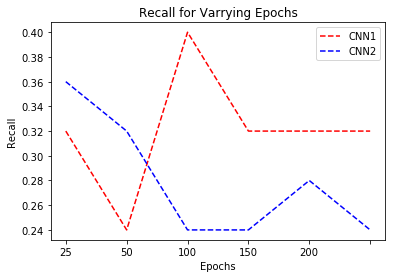

In [96]:
import matplotlib.pyplot as plt

ax = plt.subplot()
plt.plot(cnn1_scores, 'r--', label="CNN1")
plt.plot(cnn2_scores, 'b--', label="CNN2")
ax.set_xticklabels(['10', '25', '50', '100', '150', '200'])
plt.legend()
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.title("Recall for Varrying Epochs")
plt.show()

We see that CNN2 performs better for a lower number of training iterations. As we move forward, and train on more data, we will use CNN2 because we will use fewer training iterations for the full data set.

We will now compare CNN2 to a standard multi-layer perceptron.

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.neural_network import MLPClassifier

sk_mlp = MLPClassifier(hidden_layer_sizes=(100,), 
                       solver='lbfgs', 
                       learning_rate_init=0.01, 
                       max_iter=120, 
                       random_state=1)
sk_mlp.fit(X_train, y_train)

In [33]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn2 is not None:
        yhat_cnn = np.argmax(cnn2.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.recall_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = mlp.predict(X_test)
        acc_mlp = mt.recall_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

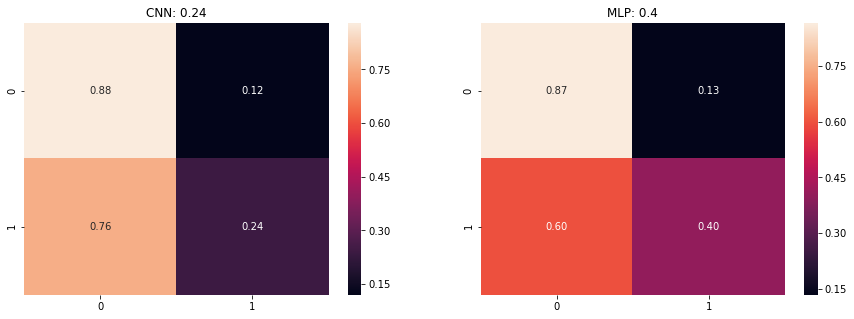

In [56]:
compare_mlp_cnn(cnn2, sk_mlp, X_test, y_test)

We see that the MLP is able to achieve better recall than our convolutional neural network for this data set size.

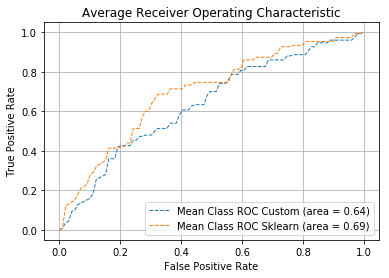

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp

K = 4

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

pred = cnn1.predict(np.expand_dims(X_test, axis=1))
pred_sk = sk_mlp.predict_proba(X_test)

perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train)

# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     pred[:,int(j)],
                                     pos_label=j)
    
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)

perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr
plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC Custom (area = %0.2f)'
               % (roc_auc))

perclass_mean_tpr = 0.0
roc_auc = 0

# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     pred_sk[:,int(j)],
                                     pos_label=j)
    
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)

perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr
plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC Sklearn (area = %0.2f)'
               % (roc_auc))

plt.legend(loc='best')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average Receiver Operating Characteristic')
plt.show()

The area under the ROC curve shows that these models perform similarly.

## Larger Data Set
We are not impressed with these results for our model, so we will now load is all available images of cars and trucks and see how CNN2 performs. We will be ignoring the class imbalance found in the real world in favor of training on all available data.

In [2]:
import numpy as np
import pandas as pd

df_labels = pd.read_csv('../Lab3/data/labels.csv')
df_labels = df_labels[ df_labels.label.isin(['automobile', 'truck']) ]
df_labels = pd.concat([df_labels[df_labels.label == "truck"],
                      df_labels[df_labels.label == "automobile"]])

from PIL import Image

# reads a png and returns a list of all pixel values in order r, g, b
def get_img_as_rgb_row(image_path):
    img = Image.open(image_path)
    if len(img.split()) == 4:
        # remove alpha if present
        r, g, b, a = img.split()
        img = Image.merge("RGB", (r, g, b))
    r, g, b = img.split()
    r = list(r.getdata())
    g = list(g.getdata())
    b = list(b.getdata())
    # convert to gray scale
    img_list = [(r[i] * 0.2989 + g[i] * 0.5870 + b[i] * 0.1140)/255 - 0.5 for i in range(len(r))]
    return img_list

# generate column names
cols = ['label']
for i in range(1024):
    cols.append("{}".format(i))

# create df and extract color values for all car and truck images
df = pd.DataFrame(columns=cols, index=range(len(df_labels.id.tolist())))
data_dir = "../Lab3/data/cifar-10/"
idx = 0
for r in df_labels.iterrows():
    entry = [r[1].label]
    entry.extend(get_img_as_rgb_row("{}{}.png".format(data_dir, r[1].id)))
    df.loc[idx] = entry
    idx += 1

label_dict = {
    'truck': 1,
    'automobile': 0
}
df['label_int'] = [label_dict[x] for x in df.label]
df.head()

,label,0,1,2,3,4,5,6,7,8,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label_int
0,truck,0.171559,0.0238604,-0.095049,-0.103683,0.0102176,0.14428,0.232866,0.264749,0.0952933,...,-0.317855,-0.243015,-0.142176,-0.0493671,0.00887686,0.0241569,0.0359204,0.0395635,0.0381557,1
1,truck,0.4999,0.492058,0.492058,0.492058,0.492058,0.492058,0.492058,0.492058,0.492058,...,-0.190953,-0.202716,-0.245849,-0.257613,-0.234085,-0.200819,-0.175799,-0.174627,-0.170706,1
2,truck,0.0391373,0.0308478,0.03202,0.0329808,0.0326604,0.0337235,0.0368353,0.00268157,-0.0103071,...,-0.355557,-0.290069,-0.14846,-0.0642176,0.000418431,0.0410804,0.0775675,0.09466,0.0893976,1
3,truck,0.107216,0.106322,0.105639,0.104509,0.107047,0.106153,0.107747,0.108152,0.104424,...,-0.053218,-0.0551153,-0.0661961,-0.0650663,-0.060251,-0.0454604,0.00489882,0.101334,0.206058,1
4,truck,0.42512,0.42512,0.432962,0.440804,0.448647,0.452568,0.459238,0.464525,0.464525,...,-0.198769,-0.179574,-0.226387,-0.243594,-0.188535,-0.143082,-0.208079,-0.224851,-0.277428,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 1026 entries, label to label_int
dtypes: int64(1), object(1025)
memory usage: 78.3+ MB


In [4]:
df.to_csv('./clean-data/all-vehicles.csv')

In [20]:
import pandas as pd
import numpy as np

df = pd.read_csv('./clean-data/all-vehicles.csv', index_col=0)

X = df.drop(['label', 'label_int'], axis=1).astype(np.float)
y = df['label_int'].astype(np.int)

print(X.shape)
print(y.shape)

(10000, 1024)
(10000,)


In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils import to_categorical

NUM_CLASSES = 2

col_names = X.columns.values

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=64)
for train_idx, test_idx in sss.split(X.values, y.values):
    # X_train - 80% training attribute set
    # X_test - 20% test attribute set
    # y_train - 80% training labels
    # y_test - 20% training labels
    X_train, X_test = pd.DataFrame(X.values[train_idx], columns=col_names), pd.DataFrame(X.values[test_idx], columns=col_names)
    y_train, y_test = pd.DataFrame(y.values[train_idx], columns=["label_int"]), pd.DataFrame(y.values[test_idx], columns=["label_int"])

y_train, y_test = y_train.values.flatten(), y_test.values.flatten()

y_train_ohe = to_categorical(y_train, NUM_CLASSES)
y_test_ohe = to_categorical(y_test, NUM_CLASSES)

In [22]:
X_train.shape

(9000, 1024)

In [23]:
class_weight = {
    1: 4,
    0: 1
}

scores = []
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
for train_idx, test_idx in kfold.split(X_train, y_train):
    # build train and test samples from crossed cols and feature cols
    X_train_temp = X_train.iloc[train_idx]
    y_train_temp = to_categorical(y_train[train_idx], NUM_CLASSES)
    X_test_temp = X_train.iloc[test_idx]
    y_test_temp = to_categorical(y_train[test_idx], NUM_CLASSES)
    
    cnn2 = build_cnn2()
    
    # fit on train and predict on test
    cnn2.fit(np.expand_dims(X_train_temp, axis=1), y_train_temp, epochs=4, batch_size=32, verbose=0)
    pred = np.argmax(cnn2.predict(np.expand_dims(X_test_temp, axis=1)), axis=1)
    
    # take cost
    s = mt.recall_score(y_train[test_idx], pred)
    scores.append(s)
    
    # print confusion matrix
    print(mt.confusion_matrix(y_train[test_idx],pred), "=>", s)



[[770 355]
 [274 851]] => 0.756444444444
[[744 381]
 [234 891]] => 0.792
[[692 433]
 [212 913]] => 0.811555555556
[[837 288]
 [332 793]] => 0.704888888889


In [201]:
cnn2 = build_cnn2()

cnn2.fit(np.expand_dims(X_train, axis=1), y_train_ohe,
        class_weight=class_weight,
        batch_size=32, epochs=4, 
        shuffle=True, verbose=0)

yhat = np.argmax(cnn2.predict(np.expand_dims(X_test, axis=1)), axis=1)
print("Recall score: " + str(mt.recall_score(y_test,yhat)))

Recall score: 0.898


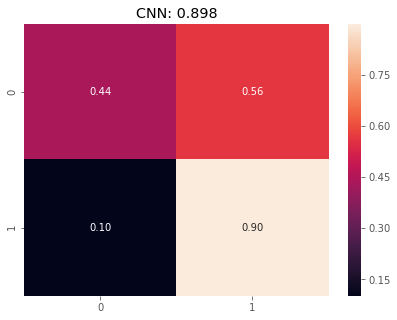

In [202]:
compare_mlp_cnn(cnn2, None, X_test, y_test)

## Data Expansion

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from skimage.io import imshow

In [25]:
NUM_CLASSES = 10
img_wh = 32

if isinstance(X_train, pd.DataFrame):
    X_train = X_train.as_matrix()
if isinstance(X_test, pd.DataFrame):
    X_test = X_test.as_matrix()

# NEW: Let's start by fixing the sizes
X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=1)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=1)
# the image data has been resized to (samples,image_channels, image_rows,image_cols)

# and one hot encoding the output values
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [26]:
print(X_train.shape)
plt.imshow(X_train[0].reshape((32, 32)), cmap=plt.cm.gray)

(9000, 1, 32, 32)


In an attempt to raise our recall score, we expanded our data set with an image generator. This will provide us with perturbed versions of our cars and trucks.

Using Keras' Image Data Generator, we used the following features to expand our images:
<ol>
<li>Image rotation: represent cameras pointed towards highways at an angle.</li>
<li>Horizontal and vertical shifts: help account for vehicles in different lanes and positions along the highway.</li>
<li>Shear: accounts for blurred images of vehicles as they drive at high speeds.</li>
<li>Horizontal flips: represents vehicles driving down different directions on the highway</li>
</ol>

In [27]:
%%time 

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=25, # used, Int. Degree range for random rotations.
    width_shift_range=0.2, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.2, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0.1, # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    data_format="channels_first")

datagen.fit(X_train)

CPU times: user 26.7 ms, sys: 27.5 ms, total: 54.2 ms
Wall time: 52.5 ms


In [28]:
X_train.shape

(9000, 1, 32, 32)

We rewrote our second network architecture to work with this reshaped data:

In [29]:
class_weight = {
    1: 4,
    0: 1
}

def build_cnn2_exp():
    cnn2 = Sequential()

    num_filters_layers = [32,32,64,128]
    for num_filters in num_filters_layers:    
        cnn2.add(Conv2D(filters=num_filters, kernel_size= (3, 3), padding='same', input_shape=(1,32,32)))
        cnn2.add(Activation('relu'))
        cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    cnn2.add(Flatten())
    cnn2.add(Dense(64))
    cnn2.add(Activation('relu'))
    cnn2.add(Dense(NUM_CLASSES))
    cnn2.add(Activation('softmax'))

    cnn2.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return cnn2

scores = []
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=64)
for train_idx, test_idx in kfold.split(X_train, y_train):
    # build train and test samples from crossed cols and feature cols
    X_train_temp = X_train[train_idx]
    y_train_temp = to_categorical(y_train[train_idx], NUM_CLASSES)
    X_test_temp = X_train[test_idx]
    y_test_temp = to_categorical(y_train[test_idx], NUM_CLASSES)

    cnn2 = build_cnn2_exp()
    
    # fit on train and predict on test
    cnn2.fit(X_train_temp, y_train_temp, epochs=4, batch_size=32, verbose=0)
    pred = np.argmax(cnn2.predict(X_test_temp), axis=1)
    
    # take cost
    s = mt.recall_score(y_train[test_idx], pred)
    scores.append(s)
    
    # print confusion matrix
    print(mt.confusion_matrix(y_train[test_idx],pred), "=>", s)

[[750 375]
 [287 838]] => 0.744888888889
[[716 409]
 [208 917]] => 0.815111111111
[[945 180]
 [545 580]] => 0.515555555556
[[901 224]
 [466 659]] => 0.585777777778


In [30]:
print(X_train.shape)
print(X_test.shape)
print(y_train_ohe.shape)
print(y_test_ohe.shape)


(9000, 1, 32, 32)
(1000, 1, 32, 32)
(9000, 10)
(1000, 10)


In [31]:
cnn2.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=32), 
                   steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                   epochs=4, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )

Epoch 1/4
281/281 [==============================] - 4s - loss: 0.0405 - acc: 0.6864 - val_loss: 0.0385 - val_acc: 0.7030
Epoch 2/4
281/281 [==============================] - 4s - loss: 0.0390 - acc: 0.6972 - val_loss: 0.0368 - val_acc: 0.7230
Epoch 3/4
281/281 [==============================] - 4s - loss: 0.0389 - acc: 0.7028 - val_loss: 0.0357 - val_acc: 0.7350
Epoch 4/4
281/281 [==============================] - 4s - loss: 0.0377 - acc: 0.7112 - val_loss: 0.0357 - val_acc: 0.7320


In [40]:
import seaborn as sns
def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn2 is not None:
        yhat_cnn = np.argmax(cnn2.predict(X_test), axis=1)
        acc_cnn = mt.recall_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = mlp.predict(X_test)
        acc_mlp = mt.recall_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

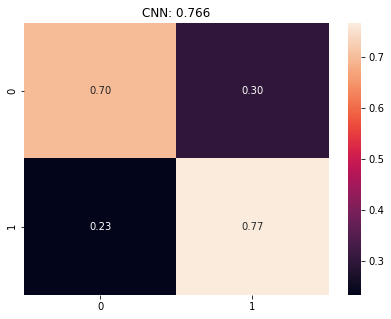

In [41]:
compare_mlp_cnn(cnn2, None, X_test, y_test)

The expanded data set of perturbed images presents what we think is a more realiztic representation of cars and trucks on a highway. Although the recal score dropped, it 

## References
Alex Krizhevsky, 2009: <a href="http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf">Learning Multiple Layers of Features from Tiny Images</a>

Face the Facts USA, 2013: <a href="https://www.facethefactsusa.org/facts/get-numbers-truck">Get the numbers of that truck</a>